# Imports

In [ ]:
from typing import List, Annotated, TypedDict

from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage

from langgraph.graph import  StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command # to implement HITL

from dotenv import load_dotenv

In [62]:
load_dotenv()

True

In [4]:
LLM = ChatGroq(model="openai/gpt-oss-20b", temperature=0.4)
LLM.invoke("Hello, I am a hooman!").content

'Hello! 👋 How can I help you today?'

HITL use cases/patterns:   
1. Action Approval Pattern (Approve / Reject Before Execution)
2. Output Review / Edit Pattern
3. Ambiguity Clarification Pattern
4. Escalation Pattern

# Simple HITL

In [12]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

We are doing HITL decision within the `chat_node`

In [ ]:
def chat(state: ChatState):
    # first interrupt the flow and wait for human feedback
    decision = interrupt(value={
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    # check the human feedback
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}
    else:
        response = LLM.invoke(state["messages"])
        return {"messages": [response]}

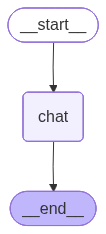

In [14]:
builder = StateGraph(ChatState)
# nodes
builder.add_node("chat", chat)
# edges
builder.add_edge(START, "chat")
builder.add_edge("chat", END)

checkpointer = MemorySaver() # Checkpointer is required for interrupts
app = builder.compile(checkpointer=checkpointer)
app

In [ ]:
CONFIG = {"configurable": {"thread_id": "sample-thread-id"}}

initial_state = {"messages": [HumanMessage(content="What is name of the largest continent by population?")]}

res = app.invoke(initial_state, config=CONFIG) # type: ignore

In [25]:
app.get_state(CONFIG) # execution is stopped for human intervention

StateSnapshot(values={'messages': [HumanMessage(content='What is name of the largest continent by population?', additional_kwargs={}, response_metadata={}, id='e80488c3-32c8-46ab-9be4-e3370e3a6680')]}, next=('chat',), config={'configurable': {'thread_id': 'sample-thread-id', 'checkpoint_ns': '', 'checkpoint_id': '1f101185-47a3-6662-8000-69b37e4ad3ba'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-02-03T15:52:23.333391+00:00', parent_config={'configurable': {'thread_id': 'sample-thread-id', 'checkpoint_ns': '', 'checkpoint_id': '1f101185-479b-6dcc-bfff-90f91bec1735'}}, tasks=(PregelTask(id='560a5a90-dd97-d538-b7e1-895e9021774d', name='chat', path=('__pregel_pull', 'chat'), error=None, interrupts=(Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'What is name of the largest continent by population?', 'instruction': 'Approve this question? yes/no'}, id='f1b8eedcf0f1da1909834256103a0fca'),), state=None, resu

In [17]:
res

{'messages': [HumanMessage(content='What is name of the largest continent by population?', additional_kwargs={}, response_metadata={}, id='e80488c3-32c8-46ab-9be4-e3370e3a6680')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'What is name of the largest continent by population?', 'instruction': 'Approve this question? yes/no'}, id='f1b8eedcf0f1da1909834256103a0fca')]}

In [28]:
res["__interrupt__"][0].value # get the interrupt message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'What is name of the largest continent by population?',
 'instruction': 'Approve this question? yes/no'}

In [29]:
user_input = input(f"\nBackend message -\n{res["__interrupt__"][0].value} \n Approve this question? (yes/no): ")

We can approve or disapprove the workflow.

In [30]:
# Resume the graph with the approval decision
result1 = app.invoke(
    Command(resume={"approved": user_input}), # value to resume execution with.
    config=CONFIG,
)

In [ ]:
app.get_state(CONFIG)
# now finally the next is "()" (empty), i.e. the workflow has completed it's execution

StateSnapshot(values={'messages': [HumanMessage(content='What is name of the largest continent by population?', additional_kwargs={}, response_metadata={}, id='e80488c3-32c8-46ab-9be4-e3370e3a6680'), AIMessage(content='Not approved.', additional_kwargs={}, response_metadata={}, id='f99857af-b3bc-4395-bf2e-481de1db6e06')]}, next=(), config={'configurable': {'thread_id': 'sample-thread-id', 'checkpoint_ns': '', 'checkpoint_id': '1f101198-0f57-6f52-8001-39ec10261e43'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-02-03T16:00:47.457852+00:00', parent_config={'configurable': {'thread_id': 'sample-thread-id', 'checkpoint_ns': '', 'checkpoint_id': '1f101185-47a3-6662-8000-69b37e4ad3ba'}}, tasks=(), interrupts=())

In [31]:
result1

{'messages': [HumanMessage(content='What is name of the largest continent by population?', additional_kwargs={}, response_metadata={}, id='e80488c3-32c8-46ab-9be4-e3370e3a6680'),
  AIMessage(content='Not approved.', additional_kwargs={}, response_metadata={}, id='f99857af-b3bc-4395-bf2e-481de1db6e06')]}

In [35]:
# try to invoke the flow again
res = app.invoke(initial_state, config=CONFIG) # type: ignore

user_input = input(f"\nBackend message -\n{res["__interrupt__"][0].value} \n Approve this question? (yes/no): ")
# Resume the graph with the approval decision
result2 = app.invoke(
    Command(resume={"approved": user_input}), # value to resume execution with.
    config=CONFIG, # type: ignore
)

In [36]:
app.get_state(CONFIG) # type: ignore
# now finally the next is "()" (empty), i.e. the workflow has completed it's execution

StateSnapshot(values={'messages': [HumanMessage(content='What is name of the largest continent by population?', additional_kwargs={}, response_metadata={}, id='e80488c3-32c8-46ab-9be4-e3370e3a6680'), AIMessage(content='Not approved.', additional_kwargs={}, response_metadata={}, id='f99857af-b3bc-4395-bf2e-481de1db6e06'), AIMessage(content='The largest continent by population is **Asia**.', additional_kwargs={'reasoning_content': 'The user asks: "What is name of the largest continent by population?" That is a straightforward factual question. The user is asking for a fact. There\'s no disallowed content. So we can answer. The policy says we can provide. There\'s no policy violation. So we can answer: Asia.'}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 90, 'total_tokens': 170, 'completion_time': 0.086194778, 'completion_tokens_details': {'reasoning_tokens': 61}, 'prompt_time': 0.007381512, 'prompt_tokens_details': None, 'queue_time': 0.048433788, 'total_

In [37]:
result2

{'messages': [HumanMessage(content='What is name of the largest continent by population?', additional_kwargs={}, response_metadata={}, id='e80488c3-32c8-46ab-9be4-e3370e3a6680'),
  AIMessage(content='Not approved.', additional_kwargs={}, response_metadata={}, id='f99857af-b3bc-4395-bf2e-481de1db6e06'),
  AIMessage(content='The largest continent by population is **Asia**.', additional_kwargs={'reasoning_content': 'The user asks: "What is name of the largest continent by population?" That is a straightforward factual question. The user is asking for a fact. There\'s no disallowed content. So we can answer. The policy says we can provide. There\'s no policy violation. So we can answer: Asia.'}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 90, 'total_tokens': 170, 'completion_time': 0.086194778, 'completion_tokens_details': {'reasoning_tokens': 61}, 'prompt_time': 0.007381512, 'prompt_tokens_details': None, 'queue_time': 0.048433788, 'total_time': 0.09357629

After approval, we are able to get answer from the LLM.

# Realtime HITL

In [64]:
import os
import requests

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

In [65]:
@tool
def get_stock_price(symbol: str) -> dict:
    """ 
    Fetch latest stock price for a given stock symbol (e.g. 'AAPL', 'TSLA', 'MSFT')
    using Alpha Vantage with API key in URL
    """
    apikey = str(os.getenv("ALPHA_VANTAGE_KEY", ""))
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey={apikey}"
    response = requests.get(url)
    return response.json()

@tool
def purchase_stock(symbol: str, quantity: int) -> dict:
    """
    Simulate purchasing a given quantity of a stock symbol.

    HUMAN-IN-THE-LOOP:
    Before confirming the purchase, this tool will interrupt
    and wait for a human decision ("yes" / anything else).
    """
    # this pauses the graph and returns control to the caller
    decision = interrupt(value=f"Approve buying {quantity} shares of {symbol}? (yes/no)")

    if isinstance(decision, str) and decision.lower() == "yes":
        return {
            "status": "success",
            "message": f"Purchase order placed for {quantity} shares of {symbol}.",
            "symbol": symbol,
            "quantity": quantity,
        }
    
    else:
        return {
            "status": "cancelled",
            "message": f"Purchase of {quantity} shares of {symbol} was declined by human.",
            "symbol": symbol,
            "quantity": quantity,
        }

tools = [get_stock_price, purchase_stock]
LLM_W_TOOLS = LLM.bind_tools(tools=tools)

**In case we did not have HITL, it can happen that the Bot can get confused and place an order for some other stock.**
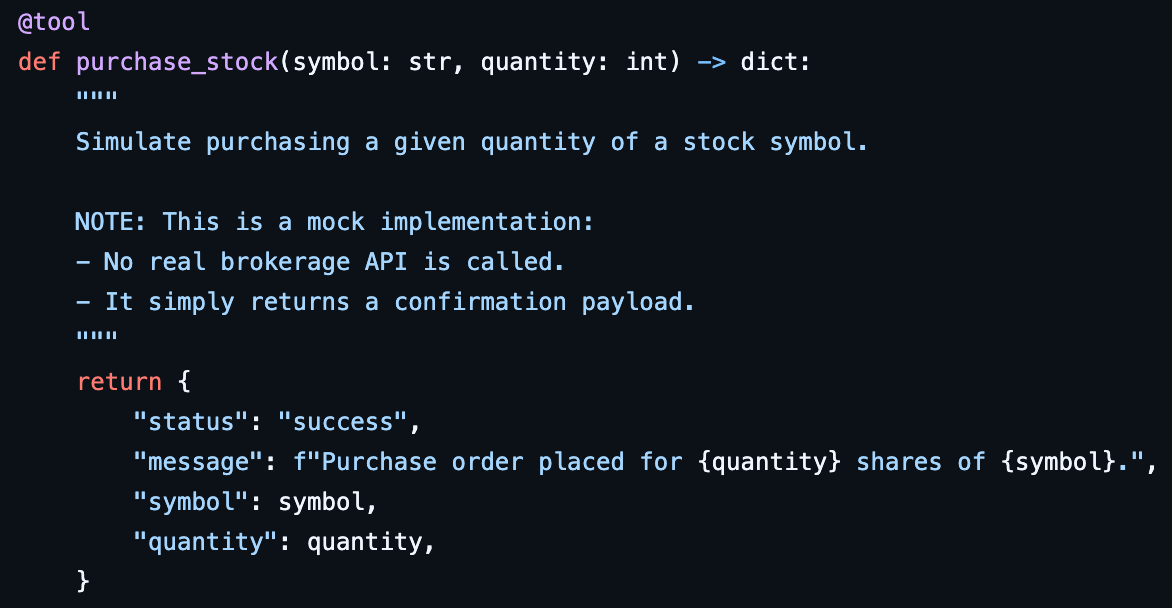

In [66]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state["messages"]
    response = LLM_W_TOOLS.invoke(messages)
    return {"messages": [response]}

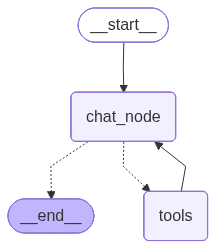

In [67]:
checkpointer = MemorySaver()
graph = StateGraph(ChatState)
# nodes
tool_node = ToolNode(tools)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)
# edges
graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")

chatbot = graph.compile(checkpointer=checkpointer)
chatbot

In [68]:
CONFIG = {"configurable":{"thread_id": "demo-thread-id-2"}}

while True:
    user_input = input("You 👦🏻: ")
    print("You 👦🏻: " + user_input)
    if user_input.lower().strip() in {"exit", "quit"}:
        print("Bot 🤖: Goodbye!")
        break

    # Build initial state for this turn
    state = {"messages": [HumanMessage(content=user_input)]}

    # Run the graph (may hit an interrupt)
    result = chatbot.invoke(
        state, # type: ignore
        config=CONFIG, # type: ignore
    )

    # Check for HITL interrupt from purchase_stock
    interrupts = result.get("__interrupt__", [])

    if interrupts:
        # Our interrupt payload is the string we passed to interrupt(...)
        # here interrupt happens inside a tool, (prev example had it in a node)
        prompt_to_human = interrupts[0].value
        print(f"HITL: {prompt_to_human}")
        decision = input("Your decision: ").strip().lower()

        # Resume graph with the human decision ("yes" / "no" / whatever)
        result = chatbot.invoke(
            Command(resume=decision),
            config=CONFIG, # type: ignore
        )

    # Get the latest message from the assistant
    messages = result["messages"]
    last_msg = messages[-1]
    print(f"Bot 🤖: {last_msg.content}\n")

You 👦🏻: what is the stock price of msft?
Bot 🤖: **MSFT (Microsoft Corp.) – Current Price (as of 2026‑02‑02)**  
- **Last traded price:** **$423.37**  
- **Day’s range:** $422.25 – $430.74  
- **Change from previous close:** –$6.92 (‑1.61 %)  

Let me know if you’d like to see more details (volume, market cap, etc.) or if you’d like to purchase shares.

You 👦🏻: buy 10 stocks of it then
HITL: Approve buying 10 shares of MSFT? (yes/no)
Bot 🤖: Got it—your request to buy 10 shares of MSFT was declined.  

If you’d like to try again, adjust the quantity, or need help with a different action (e.g., checking another stock, reviewing your portfolio, or setting up a watchlist), just let me know!

You 👦🏻: buy 10 stocks of msft
HITL: Approve buying 10 shares of MSFT? (yes/no)
Bot 🤖: ✅ **Purchase Confirmed**  
You’ve successfully placed an order for **10 shares of MSFT**.  

- **Order details:** 10 shares at the current market price of $423.37 each.  
- **Estimated cost:** $4,233.70 (plus any appli